# Analytic Sensitivity Estimates for LLP Searches at Tera-Z Factories

**Authors:** Marco Drewes, Juraj Klarić, and Yuan-Zhen Li  
**Reference:** [arXiv:2511.23461](https:arxiv.org/abs/2511.23461) (New Particles at the Z-Pole: Tera-Z factories as discovery and precision machines)

### Overview
This notebook implements the analytic formulae derived in the associated paper to estimate the sensitivity of future Z-factories (FCC-ee, CEPC, LEP3 and LEP-Z) to Long-Lived Particles (LLPs). 

It explores the dependence of the sensitivity region on:
1.  **Integrated Luminosity:** Total number of produced X-particles ($N_{\rm prod} \propto \epsilon_{\rm prod} \, N_Z$).
2.  **Detector Size:** Evaluated by the fiducial volume defined by length ($l_{cyl}$) and radius ($d_{cyl}$).
3.  **Backgrounds:** LLP searches can often be considered background-free if $\lambda_N$ exceeds some critical value $l_0$.

Two benchmark models are implemented:
* **Heavy Neutral Leptons (HNLs)**
* **Axion-Like Particles (ALPs)** 

## General setting

In [1]:
from pathlib import Path
import numpy as np
from scipy.interpolate import interp1d
from scipy.special import lambertw 
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.path as mpath

# Plotting Style Configuration
%matplotlib inline
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'xtick.major.pad': 8})
matplotlib.rc('font', **{'family': 'serif', 'serif': ['Computer Modern'],'size': 16})
matplotlib.rc('text', usetex=True) # Requires LaTeX installed on system
matplotlib.rc('legend', fontsize=16)

# rcParams.update({
#     'figure.autolayout': True,
#     'text.usetex': True,  # 关键：关闭 LaTeX 渲染，因为它默认使用衬线体
#     'font.family': 'sans-serif',
#     'font.sans-serif': ['Arial', 'Helvetica', 'DejaVu Sans'], # 优先使用 Arial
#     'mathtext.fontset': 'custom', # 自定义数学字体，使其与 Arial 一致
#     'mathtext.rm': 'Arial',
#     'mathtext.it': 'Arial:italic',
#     'mathtext.bf': 'Arial:bold',
#     'mathtext.default': 'regular', # 让数学符号也使用非衬线体
# })

# Color Scheme Definition
Dark_Red = '#B30000'
Dark_Blue = '#0000B3'
Dark_Green = '#00B300'
Light_Brown = '#E0D1C2'
Dark_Brown =  '#6B4724'
Dark_Gray = '#CCCCCC'
Light_Gray = '#B3B3B3'

# Line Styles
line_width = 2.4
tick_font_size = 20
label_font_size = 18
legend_font_size = 18

### Constants of Nature (Natural Units)

In [2]:
GeV = 1   # Convenient choice for Tera-Z
eV = 1e-9 # Useful for HNLs
cm = 1.0 / (1.98e-14 * GeV)  # Conversion factor for length
GF = 1.16e-5 / GeV**2        # Fermi Constant
mZ = 91.2 * GeV              # Z-boson mass
GammaZ = 2.4955 * GeV        # Total Z-boson width
sW = np.sqrt(0.22)              # Sine of Weinberg angle
cW = np.sqrt(1-0.22)            # Cosine of Weinberg angle
alpha = 1.0/137.0            # Fine structure constant

## Two body Z boson decay kinematics and LLP event numbers

In [3]:
def pX(M):
    """
    Calculates the 3-momentum of the LLP produced in a 2-body Z-decay.
    Assumes Z-boson is at rest and the masses of all the other particles are negligible.
    
    Parameters:
        M: Mass of the LLP [GeV]
    """
    return mZ / 2.0 * (1 - (M / mZ)**2)

def lambdaX(M, epsilon_dec, Gamma_tot_func):
    """
    Calculates the decay length of the LLP in the laboratory frame.
    Equation (3): lambda = (p/m) * (1/Gamma_tot)
    
    Parameters:
        M: Mass of the LLP [GeV]
        epsilon_dec: Effective coupling governing decay
        Gamma_tot_func: Function to calculate total decay width
    """
    return pX(M) / M / Gamma_tot_func(M, epsilon_dec)

def Nobs(M, epsilon_pro, epsilon_dec, NZ, l0, l1, model):
    """
    Master Formula for Number of Observed Events (Eq. 5 in paper).

    N_obs = N_prod * Probability_decay_in_volume * Branching_ratio_visible

    Parameters:
        M:           LLP Mass [GeV]
        epsilon_pro: Effective coupling governing production
        epsilon_dec: Effective coupling governing decay
        NZ:          Total Z-bosons produced
        l0, l1:      Detector geometry constraints (min/max decay length)
        model:       Dictionary with keys 'B', 'Gamma_vis', 'Gamma_tot'
                     containing the model-specific physics functions

    Returns:
        Number of observable LLP decay events
    """
    # Extract physics functions from model dictionary
    B_func = model['B']
    Gamma_vis_func = model['Gamma_vis']
    Gamma_tot_func = model['Gamma_tot']

    # 1. Total Production Rate: NZ * epsilon_pro * B_factor
    # 2. Geometric Acceptance: exp(-l0/lam) - exp(-l1/lam)
    # 3. Visible Branching: epsilon_dec*Gamma_vis / Gamma_tot

    decay_len = lambdaX(M, epsilon_dec, Gamma_tot_func)
    geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))

    result = (NZ * epsilon_pro * B_func(M)) * \
             geom_factor * \
             (epsilon_dec * Gamma_vis_func(M) / Gamma_tot_func(M, epsilon_dec))

    return result

## LLP model definitions and model-specific physics functions

Each LLP model requires three functions:
1. **B(M)** - Kinematic branching factor for Z decay
2. **Gamma_vis(M)** - Visible decay width (normalized by coupling)
3. **Gamma_tot(M, epsilon_dec)** - Total decay width

### Heavy Neutral Leptons (HNLs)

In [4]:
def B_HNL(M):
    """
    Kinematic branching factor for Z -> nu N (HNL production).
    Equation (24) in paper.
    """
    return 2/15 * (2 * pX(M) / mZ)**2 * (1 + (M / mZ)**2 / 2)

def Gamma_vis_HNL(M):
    """
    Reduced visible decay width for HNL (normalized by coupling U^2).
    Proportional to G_F^2 * M^5.
    Equation (23) in paper.
    """
    cfactor = 2.0  # 2 for Majorana, 1 for Dirac HNLs
    return 11 * cfactor / 192 / np.pi**3 * M**5 * GF**2

def Gamma_inv_HNL(M, epsilon_dec):
    """
    Invisible decay width for HNL, negligible in our case.
    """
    cfactor = 2.0 # 2 for Majorana, 1 for Dirac HNLs
    return cfactor / 192 / np.pi**3 * M**5 * GF**2 * epsilon_dec

def Gamma_tot_HNL(M, epsilon_dec):
    """
    Total decay rate of HNL, including both the visible part and the invisible part.
    """
    return epsilon_dec * Gamma_vis_HNL(M) + Gamma_inv_HNL(M, epsilon_dec)

HNL = {
    'name': 'HNL',
    'B': B_HNL,
    'Gamma_vis': Gamma_vis_HNL,
    'Gamma_inv': Gamma_inv_HNL,
    'Gamma_tot': Gamma_tot_HNL,
    'epsilon_label': r'$U^2$',
    'epsilon_pro': lambda U2: U2,           # Production coupling
    'epsilon_dec': lambda U2: U2,           # Decay coupling
    'coupling_from_epsilon': lambda eps: eps  # Inverse: epsilon -> coupling (identity for HNL)
}

### Axion-Like Particles (ALPs)

In [5]:
def B_ALP(M):
    """
    Kinematic branching factor for Z -> gamma a (ALP production).
    Equation (31) in paper.
    """
    return mZ/GammaZ * (sW/cW)**2 * alpha**2/96/np.pi**3 * (1-(M/mZ)**2)**3

def Gamma_vis_ALP(M):
    """
    Reduced visible decay width for ALP (normalized by coupling).
    Proportional to alpha^2 * M^3 (photonic decay a -> gamma gamma).
    Equation (30) in paper.
    """
    return alpha**2 * M**3 / 64 / np.pi**3 / mZ**2

def Gamma_inv_ALP(M):
    """
    Invisible decay width for ALP, negligible in our case.
    """
    return 0

def Gamma_tot_ALP(M, epsilon_dec):
    """
    Total decay rate of ALP, including both the visible part (epsilon_dec * Gamma_vis_ALP(M)) and the invisible part (Gamma_inv_ALP).
    """
    return epsilon_dec * Gamma_vis_ALP(M) + Gamma_inv_ALP(M)

# ALP decay constant
f_ALP = 1000 * GeV  # 1 TeV

ALP = {
    'name': 'ALP',
    'B': B_ALP,
    'Gamma_vis': Gamma_vis_ALP,
    'Gamma_inv': Gamma_inv_ALP,
    'Gamma_tot': Gamma_tot_ALP,
    'epsilon_label': r"$c_{\gamma \gamma} /f \,\, [{\rm TeV}^{-1}]$",
    'epsilon_pro': lambda cgg: (-sW**2 * cgg)**2 / sW**4 * (mZ/f_ALP)**2,  # Z-gamma coupling
    'epsilon_dec': lambda cgg: cgg**2 * (mZ/f_ALP)**2,                      # gamma-gamma coupling
    'coupling_from_epsilon': lambda eps: np.sqrt(eps) * f_ALP/mZ            # Inverse: epsilon -> c_gamma_gamma
}

## Analytic Sensitivity Boundaries

Functions to calculate the theoretical limits of the sensitivity region.

In [6]:
def LLP_underproduced(model, NZ, M, l0):
    """
    Lower bound on coupling from integrated luminosity.
    Condition: Total produced LLPs > Nmin.
    Corresponds to too few LLPs being produced.

    Parameters:
        model: Model dictionary
        NZ: Number of Z bosons
        M: Mass or array of masses [GeV]

    Returns:
        Coupling value(s) at the boundary
    """
    Nmin = 4  # Minimum events for discovery
    # For HNL: epsilon_pro = U^2, so coupling = U^2
    # For ALP: need to invert epsilon_pro function
    # This is model-specific, returning epsilon_bound for now
    term = - Nmin / NZ / model['B'](M) / (pX(M) / M) * l0 * model['Gamma_vis'](M)
    if l0!=0:
        epsilon_bound = - (pX(M)/M) / l0 / model['Gamma_vis'](M) * lambertw(term)
    else:
        epsilon_bound =  Nmin / NZ / model['B'](M)
    return model['coupling_from_epsilon'](epsilon_bound)


def LLP_escapes(model, NZ, M, l1):
    """
    Lower bound on coupling for very long-lived particles.
    Condition: LLPs must decay before escaping detector.
    Limited by detector size.

    Parameters:
        model: Model dictionary
        NZ: Number of Z bosons
        M: Mass or array of masses [GeV]
        l1: Maximum decay length (detector size)

    Returns:
        Coupling value(s) at the boundary
    """
    Nmin = 4
    epsilon_bound = np.sqrt(Nmin / NZ / model['B'](M) * pX(M) / M / l1 / model['Gamma_vis'](M))
    return model['coupling_from_epsilon'](epsilon_bound)


def LLP_prompt(model, NZ, M, l0):
    """
    Upper bound on coupling due to short lifetime / backgrounds.
    Condition: LLPs must decay after minimum distance l0 (vertex displacement).

    Parameters:
        model: Model dictionary
        NZ: Number of Z bosons
        M: Mass or array of masses [GeV]
        l0: Minimum decay length (background suppression cut)

    Returns:
        Coupling value(s) at the boundary
    """
    Nmin = 4
    term = - Nmin / NZ / model['B'](M) / (pX(M) / M) * l0 * model['Gamma_vis'](M)
    epsilon_bound = -(pX(M) / M) / l0 / model['Gamma_vis'](M) * lambertw(term, k=-1)
    return model['coupling_from_epsilon'](epsilon_bound)

## Sensitivity Grid Generation

Calculate the number of observed events on a 2D grid of (mass, coupling) values.

In [7]:
def calculate_sensitivity_grid(model, mass_range, coupling_range,
                               l0, l1, plot_points=1000):
    """
    Calculate normalized sensitivity grid (per Z boson).

    Parameters:
        model: Model dictionary containing physics functions
        mass_range: (M_min, M_max) in GeV
        coupling_range: (coupling_min, coupling_max) - physical coupling parameter
        l0, l1: Detector geometry (min/max decay length) in natural units (use the conversion factors)
        plot_points: Grid resolution (default 1000)

    Returns:
        M_grid: 2D array of mass values [GeV]
        coupling_grid: 2D array of coupling values
        log_Nobs_per_NZ: log10(Nobs/NZ) - number of events per Z boson (log scale)

    Note: To get Nobs for a specific luminosity NZ, add log10(NZ) to log_Nobs_per_NZ.
          For example: log_Nobs = log_Nobs_per_NZ + np.log10(NZ)
    """
    # Create 1D arrays in log space
    M_vals = np.logspace(np.log10(mass_range[0]), np.log10(mass_range[1]), plot_points)
    coupling_vals = np.logspace(np.log10(coupling_range[0]), np.log10(coupling_range[1]), plot_points)

    # Create 2D meshgrids
    M_grid, coupling_grid = np.meshgrid(M_vals, coupling_vals)

    # Convert physical coupling to epsilon_pro and epsilon_dec using model functions
    epsilon_pro_grid = model['epsilon_pro'](coupling_grid)
    epsilon_dec_grid = model['epsilon_dec'](coupling_grid)

    # Calculate Nobs with NZ=1 (normalized per Z boson)
    Nobs_grid = Nobs(M_grid, epsilon_pro_grid, epsilon_dec_grid,
                     NZ=1.0, l0=l0, l1=l1, model=model)

    return M_grid, coupling_grid, np.log10(Nobs_grid)

## Plotting Helper Functions

Composable functions for building sensitivity plots with matplotlib.

In [8]:
def add_sensitivity_contours(ax, M_grid, coupling_grid, log_Nobs_per_NZ,
                            event_levels, NZ, colors,
                            linestyles='dashed', linewidth=2.4):
    """
    Add sensitivity contour lines to existing axes.

    Parameters:
        ax: Matplotlib axes object
        M_grid, coupling_grid: 2D meshgrids of mass and coupling values
        log_Nobs_per_NZ: log10(Nobs/NZ) grid from calculate_sensitivity_grid
        event_levels: List of event numbers to contour (e.g., [1, 10, 100])
        NZ: Total number of Z bosons for this plot
        colors: List of colors for each contour level
        linestyles: Line style(s) for contours
        linewidth: Line width for contours

    Returns:
        Contour object from matplotlib
    """
    # Convert event numbers to log levels accounting for NZ
    log_levels = np.log10(event_levels) - np.log10(NZ)

    cs = ax.contour(M_grid, coupling_grid, log_Nobs_per_NZ,
                   levels=log_levels, colors=colors,
                   linewidths=linewidth, linestyles=linestyles)
    return cs

def add_constraint_region(ax, data_file, fill_direction='up',
                         color='gray', alpha=1.0, zorder=2):
    """
    Add filled constraint region from CSV data file.

    Parameters:
        ax: Matplotlib axes object
        data_file: Path to CSV file (accepts string or Path object)
        fill_direction: 'up' to fill above curve, 'down' to fill below
        color: Fill color
        alpha: Transparency (0=transparent, 1=opaque)
        zorder: Drawing order (higher=on top)

    Returns:
        2D numpy array with shape (n_points, 2)
    """
    # Convert Path object to string if needed
    data_file = str(data_file)
    data = np.genfromtxt(data_file, comments='#', delimiter=',')

    if data.size == 0:
        return data

    y_fill = 1e10 if fill_direction == 'up' else 1e-20
    ax.fill_between(data[:, 0], data[:, 1], y_fill,
                   facecolor=color, alpha=alpha, zorder=zorder)
    return data

In [9]:
def Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename):
    """
    Main Plot functions for the sensitivity region.
    """
    # Read parameters for the model and detector geometry
    LLP_model = model_parameters['LLP_model']
    mass_range = model_parameters['mass_range']
    coupling_range = model_parameters['coupling_range']
    event_levels = model_parameters['event_levels']
    event_levels_specific = model_parameters['event_levels_specific']
    colors_specific = model_parameters['colors_specific']
    NZ = model_parameters['NZ']

    l0_contour = geometry_parameters['l0_contour']
    l0 = geometry_parameters['l0']
    l1 = geometry_parameters['l1']

    # Calculate the sensitivity grid
    M_grid, U2_grid, log_Nobs_per_NZ = calculate_sensitivity_grid(
        LLP_model,
        mass_range = mass_range,
        coupling_range= coupling_range,
        l0=l0_contour,  
        l1=l1,
        plot_points = 1000
    )

    # Set up the plot
    fig, ax = plt.subplots(figsize=(10, 8))
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_axisbelow(False)

    num_levels = len(event_levels)
    # Change here if you want to define your color map.
    cmap_purple = LinearSegmentedColormap.from_list("myPurpleGradient", ['#D8BFD8', '#4B0082'])
    min_intensity = 0.4
    colors = [cmap_purple(min_intensity + (1.0 - min_intensity) * (i / (num_levels - 1))) for i in range(num_levels)]

    # Add sensitivity contours
    cs = add_sensitivity_contours(ax, M_grid, U2_grid, log_Nobs_per_NZ,
                                 event_levels = event_levels, NZ = NZ,
                                 colors = colors, linestyles='dashed')
    cs1 = add_sensitivity_contours(ax, M_grid, U2_grid, log_Nobs_per_NZ,
                                 event_levels = event_levels_specific, NZ = NZ,
                                 colors = colors_specific, linestyles='solid')
    
    # Add analytical sensitivity boundaries
    if boundary_parameters != {}:
        M_boundary = boundary_parameters['M_boundary']
        boundary_list = boundary_parameters['boundary_list']
        
        for boundary in boundary_list:
            if boundary == LLP_escapes:
                ax.plot(M_boundary, boundary(LLP_model, NZ, M_boundary, l1), color=Dark_Blue, linewidth=line_width)
            elif boundary == LLP_underproduced:
                ax.plot(M_boundary, boundary(LLP_model, NZ, M_boundary, l0), color=Dark_Red, linewidth=line_width)
            elif boundary == LLP_prompt:
                ax.plot(M_boundary, boundary(LLP_model, NZ, M_boundary, l0), color=Dark_Green, linewidth=line_width)
            else:
                print('Un-implemented boundary. You need define your own boundary functions!')
                
    # Add constraint region
    if constraints_parameters != {}:
        Constraints_Astro = constraints_parameters['Constraints_Astro']
        Constraints_Direct = constraints_parameters['Constraints_Direct']
        Constraints_Add = constraints_parameters['Constraints_Add']
        
        for constraint in Constraints_Astro:
            add_constraint_region(ax, Path(constraint),fill_direction='down', color = Light_Gray)
            
        for constraint in Constraints_Direct:
            add_constraint_region(ax, Path(constraint), color = Dark_Gray)
            
        for constraint in Constraints_Add:
            data_file = str(Path(constraint))
            data = np.genfromtxt(data_file, comments='#', delimiter=',')
            ax.fill_between(data[:, 0], data[:, 1], data[:, 2],
                   facecolor=Light_Brown, alpha=1.0, zorder = 1)

    # Add label for the contours
    if 'Labels_Contour' in labels_parameters:
        Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels, font_size = labels_parameters['Labels_Contour']
        for i in range(num_levels):
            ax.text(Labels_Contour_positions_x[i], Labels_Contour_positions_y[i], Labels_Contour_labels[i], color= colors[i], fontsize = font_size, ha='center')
    
    Labels_Contour_specific = labels_parameters['Labels_Contour_specific']
    for label in Labels_Contour_specific:
        ax.text(label[0], label[1], label[2], c=label[3], fontsize=label[4],  ha='center', va='center')
        
    # Add label for the boundaries and constraints
    Labels_Boundaries = labels_parameters['Labels_Boundaries']
    Labels_Constraints_Direct = labels_parameters['Labels_Constraints_Direct']
    Labels_Constraints_Astro = labels_parameters['Labels_Constraints_Astro']
    Labels_Constraints_Add = labels_parameters['Labels_Constraints_Add']
    for label in Labels_Boundaries:
        ax.text(label[0], label[1], label[2], c=label[3], fontsize=label[4],  ha='center', va='center')
    for label in Labels_Constraints_Direct:
        ax.text(label[0], label[1], label[2], c=label[3], fontsize=label[4],  ha='center', va='center')
    for label in Labels_Constraints_Astro:
        ax.text(label[0], label[1], label[2], c=label[3], fontsize=label[4],  ha='center', va='center')
    for label in Labels_Constraints_Add:
        ax.text(label[0], label[1], label[2], c=label[3], fontsize=label[4],  ha='center', va='center')
        
    ax.set_xlim(mass_range)
    ax.set_ylim(coupling_range)
    ax.set_xlabel("M [GeV]", fontsize=legend_font_size)
    ax.set_ylabel(LLP_model['epsilon_label'], fontsize=legend_font_size)
    # ax.tick_params(axis='both', which='major', labelsize=tick_font_size)

    ax.tick_params(which='both',  direction='in', labelsize=tick_font_size,
               top=True,   right=True,  bottom=True,left=True)
    ax.tick_params(which='major', length=6)
    ax.tick_params(which='minor', length=3)

    plt.savefig(filename)
    print(f"Plot saved to "+filename)

## Example Plots

### HNL Sensitivity Plot (Fixed NZ)

/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: overflow encountered in exp
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/4290521442.py:36: RuntimeWarning: invalid value encountered in log10
  return M_grid, coupling_grid, np.log10(Nobs_grid)
/Users/yuanzhenli/Miniconda3/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/yuanzhenli/Miniconda3/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Plot saved to Sensitivity_HNL_NZ_6e+12.pdf


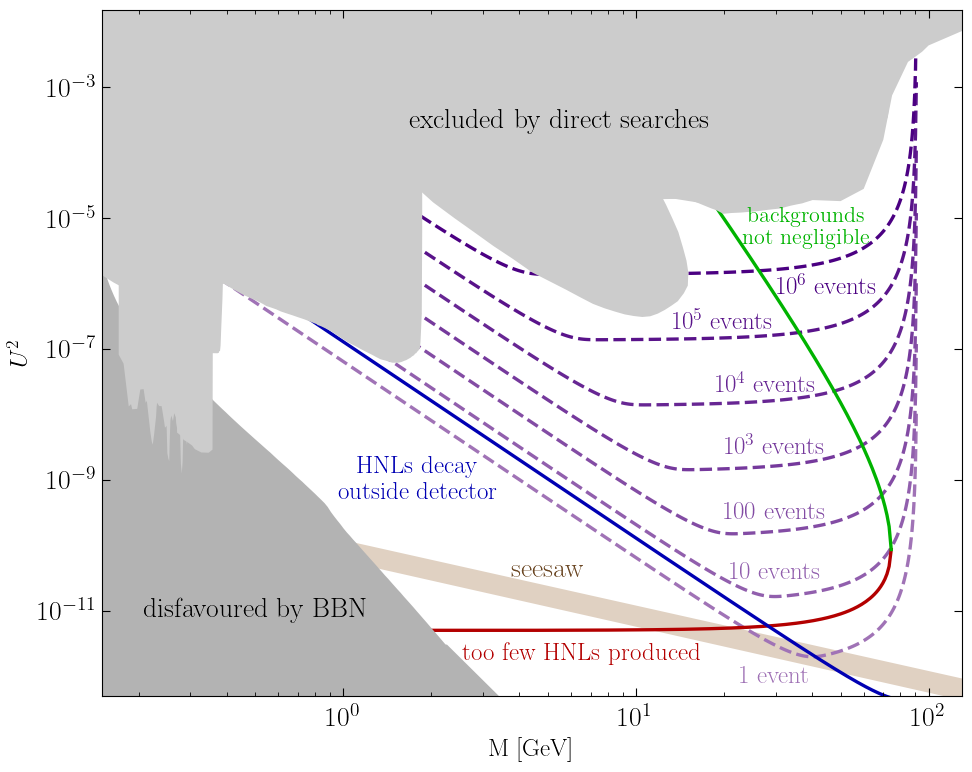

In [10]:
# ===================================================
# 1. Set model parameters for the sensitivity region
# ===================================================
NZ = 6e12                   # Number of produced Z bosons
LLP_model = HNL
mass_range = (0.15, 130)     # mass_range and coupling_range are also used to set the xlim and ylim of the final figure
coupling_range = (5e-13, 1.5e-2)
event_levels = [1, 10, 100, 1000, 1e4, 1e5, 1e6]

event_levels_specific = [ ] #Specific levels with solid lines and user-defined colors
colors_specific = [ ]

model_parameters = {
    'LLP_model': HNL,
    'mass_range': mass_range,
    'coupling_range': coupling_range,
    'event_levels': event_levels,
    'event_levels_specific': event_levels_specific,
    'colors_specific': colors_specific,
    'NZ': NZ
}

# ===================================================
# 2. Set Detector geometry
# ===================================================
l0 = 0.04 * cm              # Background suppression cut given by minimal detectable displacement, can be set to 0 if backgrounds can be reduced in other ways
l0_contour = 0              # Set background-free for demonstration when plotting the contours

l_cyl = 11 * 100 * cm       # Length: 11 meters
d_cyl = 2 * 100 * 4.5 * cm  # Diameter: 9 meters
l1 = 0.5 * (1.5)**(1/3) * d_cyl**(2/3) * l_cyl**(1/3)  # Effective detector size

geometry_parameters = {
    'l0_contour': l0_contour,
    'l0': l0,
    'l1': l1
}

# ===================================================
# 3. Set parameters for the analytic sensitivity boundaries
# ===================================================
Show_boundaries = True     # Set to False if you don't want to show any analytic sensitivity boundaries
if Show_boundaries:
    boundary_list = [LLP_underproduced, LLP_prompt, LLP_escapes]
    Mmax_boundary = 74.5
    M_boundary = np.logspace(np.log10(0.1), np.log10(Mmax_boundary), 400)
    boundary_parameters = {
        'M_boundary': M_boundary,
        'boundary_list': boundary_list
    }
else:
    boundary_parameters = {
    }

# ===================================================
# 4. Add constraint regions for the LLP
# ===================================================
Show_constraints = True     # Set to False if you don't want to show any constraints
if Show_constraints:
    data_dir = "HNLConstraints/"
    HNL_Constraints_Direct = [
    data_dir + "gambitEWPD.csv",
    data_dir + "Umu-ATLAS-displaced.csv",
    data_dir + "Umu-ATLAS-prompt.csv",
    data_dir + "Umu-CHARM.csv",
    data_dir + "Umu-CMS-13TeV.csv",
    data_dir + "Umu-CMS-longlived.csv",
    data_dir + "Umu-DELPHI-longlived.csv",
    data_dir + "Umu-DELPHI-shortlived.csv",
    data_dir + "Umu-E949.csv",
    data_dir + "Umu-KEK.csv",
    data_dir + "Umu-NuTeV.csv",
    data_dir + "Umu-PS191.csv",
    data_dir + "Umu-SIN.csv"
    ]
    HNL_Constraints_Astro = [
    data_dir + "Umu-BBN_BoyarskyExtra.csv"
    ]
    HNL_seesaw = [
    data_dir + "seesaw.csv"
    ]

    constraints_parameters = {
        'Constraints_Direct': HNL_Constraints_Direct,
        'Constraints_Astro': HNL_Constraints_Astro,
        'Constraints_Add': HNL_seesaw
    }
else:
    constraints_parameters = {
    }

# ===================================================
# 5. Add labels for the sensitivity region
# ===================================================
label_font_size = 18
def generate_label(N_events):
    if N_events >= 1000:
        label = f"$10^{int(np.log10(N_events))}$ events"
    elif N_events >= 10:
        label = f"${int(N_events)}$ events"
    else:
        label = f"{int(N_events)} event{'s' if N_events > 1 else ''}"
    return label
    
Labels_Contour_positions_x = [30, 30, 30, 30, 28, 20, 45]
Labels_Contour_positions_y = [8e-13, 3e-11, 2.5e-10, 2.5e-9, 2.2e-8, 2e-7, 7e-7]
Labels_Contour_labels = [generate_label(level) for level in event_levels]
Labels_Contour = [Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels, label_font_size]

Labels_Contour_specific = [
   
]

if Show_boundaries:
    Labels_Boundaries = [
        [ 6.5, 2.2e-12, "too few HNLs produced", Dark_Red, label_font_size],
        [ 1.8, 1e-9, "HNLs decay \n outside detector", Dark_Blue, label_font_size],
        [38, 7e-6, "backgrounds \n not negligible", Dark_Green, label_font_size-2],
    ]
else:
    Labels_Boundaries = []
    
if Show_constraints:
    Labels_Constraints_Direct = [
        # [30, 2e-4, "DELPHI", 'black' ],
        # [9, 2e-6, "CMS", 'black' ],
        # [1, 2e-6, "NuTeV", 'black' ]
        [5.5, 3e-4, "excluded by direct searches", 'black', label_font_size + 2]
    ]
    
    Labels_Constraints_Astro = [
        [0.5, 1e-11, "disfavoured by BBN", 'black', label_font_size + 2]
    ]
    
    Labels_Constraints_Add = [
        [ 5, 0.42e-10, "seesaw", Dark_Brown, label_font_size + 2]
    ]
else:
    Labels_Constraints_Direct = []
    Labels_Constraints_Astro = []
    Labels_Constraints_Add = []

labels_parameters = {
    'Labels_Contour': Labels_Contour,
    'Labels_Contour_specific': Labels_Contour_specific,
    'Labels_Boundaries': Labels_Boundaries,
    'Labels_Constraints_Direct': Labels_Constraints_Direct,
    'Labels_Constraints_Astro': Labels_Constraints_Astro,
    'Labels_Constraints_Add': Labels_Constraints_Add
}

# ===================================================
# 6. Save the plot
# ===================================================
filename = f"Sensitivity_{LLP_model['name']}_NZ_{NZ:.0e}.pdf"

# ===================================================
# 7. Run the main plot function
# ===================================================
Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename)

### HNL Sensitivity Plot (Fixed Nobs)

/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: overflow encountered in exp
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/4290521442.py:36: RuntimeWarning: invalid value encountered in log10
  return M_grid, coupling_grid, np.log10(Nobs_grid)


Plot saved to Sensitivity_HNL_Nmin_4e+00.pdf


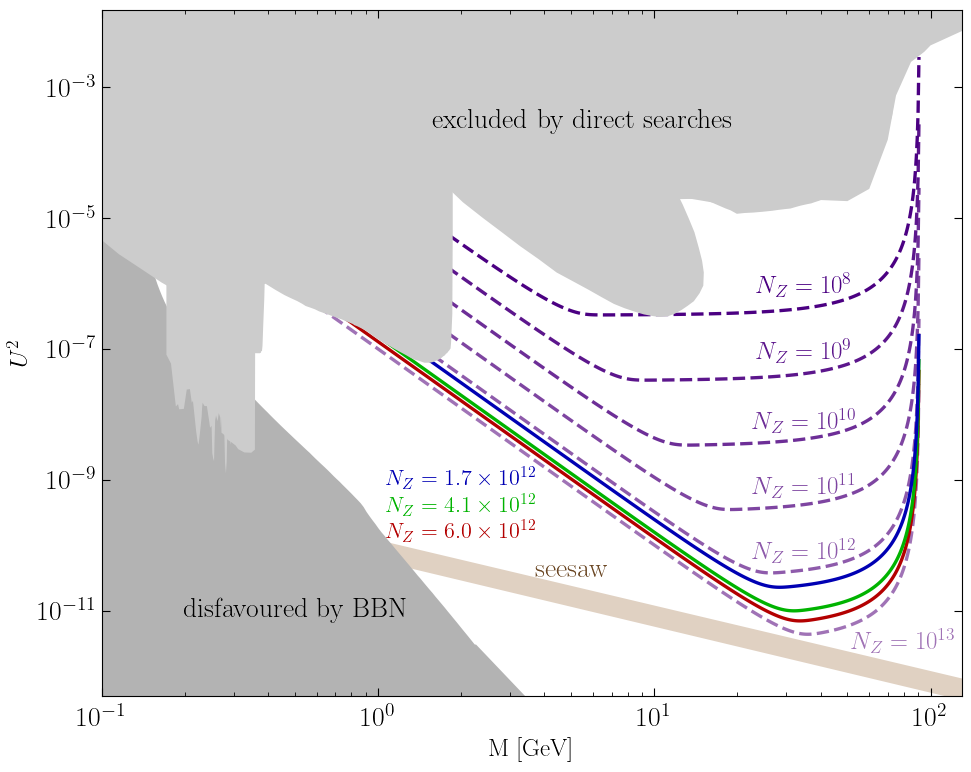

In [11]:
# ===================================================
# 1. Set model parameters for the sensitivity region
# ===================================================
Nmin = 4                    # Number of minimum observed events
NZ = 1e13                   # Number of produced Z bosons
LLP_model = HNL
mass_range = (0.1, 130)     # mass_range and coupling_range are also used to set the xlim and ylim of the final figure
coupling_range = (5e-13, 1.5e-2)
NZ_levels = np.array([1e13, 1e12, 1e11, 1e10, 1e9, 1e8])
event_levels = Nmin * NZ / NZ_levels

NZ_levels_specific = np.array([6e12, 4.1e12, 1.7e12])
event_levels_specific = Nmin * NZ / NZ_levels_specific #Specific levels with solid lines and user-defined colors
colors_specific = [Dark_Red, Dark_Green, Dark_Blue]

model_parameters = {
    'LLP_model': HNL,
    'mass_range': mass_range,
    'coupling_range': coupling_range,
    'event_levels': event_levels,
    'event_levels_specific': event_levels_specific,
    'colors_specific': colors_specific,
    'NZ': NZ
}

# ===================================================
# 2. Set Detector geometry
# ===================================================
l0 = 0.04 * cm              # Background suppression cut given by minimal detectable displacement, can be set to 0 if backgrounds can be reduced in other ways
l0_contour = 0              # Set background-free for demonstration when plotting the contours

l_cyl = 11 * 100 * cm       # Length: 11 meters
d_cyl = 2 * 100 * 4.5 * cm  # Diameter: 9 meters
l1 = 0.5 * (1.5)**(1/3) * d_cyl**(2/3) * l_cyl**(1/3)  # Effective detector size

geometry_parameters = {
    'l0_contour': l0_contour,
    'l0': l0,
    'l1': l1
}

# ===================================================
# 3. Set parameters for the analytic sensitivity boundaries
# ===================================================
Show_boundaries = False     # Set to False if you don't want to show any analytic sensitivity boundaries
if Show_boundaries:
    boundary_list = [LLP_underproduced, LLP_prompt, LLP_escapes]
    Mmax_boundary = 74.5
    M_boundary = np.logspace(np.log10(0.1), np.log10(Mmax_boundary), 400)
    boundary_parameters = {
        'M_boundary': M_boundary,
        'boundary_list': boundary_list
    }
else:
    boundary_parameters = {
    }

# ===================================================
# 4. Add constraint regions for the LLP
# ===================================================
Show_constraints = True     # Set to False if you don't want to show any constraints
if Show_constraints:
    data_dir = "HNLConstraints/"
    HNL_Constraints_Direct = [
    data_dir + "gambitEWPD.csv",
    data_dir + "Umu-ATLAS-displaced.csv",
    data_dir + "Umu-ATLAS-prompt.csv",
    data_dir + "Umu-CHARM.csv",
    data_dir + "Umu-CMS-13TeV.csv",
    data_dir + "Umu-CMS-longlived.csv",
    data_dir + "Umu-DELPHI-longlived.csv",
    data_dir + "Umu-DELPHI-shortlived.csv",
    data_dir + "Umu-E949.csv",
    data_dir + "Umu-KEK.csv",
    data_dir + "Umu-NuTeV.csv",
    data_dir + "Umu-PS191.csv",
    data_dir + "Umu-SIN.csv"
    ]
    HNL_Constraints_Astro = [
    data_dir + "Umu-BBN_BoyarskyExtra.csv"
    ]
    HNL_seesaw = [
    data_dir + "seesaw.csv"
    ]

    constraints_parameters = {
        'Constraints_Direct': HNL_Constraints_Direct,
        'Constraints_Astro': HNL_Constraints_Astro,
        'Constraints_Add': HNL_seesaw
    }
else:
    constraints_parameters = {
    }

# ===================================================
# 5. Add labels for the sensitivity region
# ===================================================
label_font_size = 18
def generate_label(NZ):
    label = f"$N_Z = 10^{{{int(np.log10(NZ))}}}$"
    return label
    
Labels_Contour_positions_x = [80, 35, 35, 35, 35, 35]
Labels_Contour_positions_y = [2.6e-12, 6e-11, 6e-10, 6e-9, 7e-8, 7e-7]
Labels_Contour_labels = [generate_label(level) for level in NZ_levels]
Labels_Contour = [Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels, label_font_size]

Labels_Contour_specific = [
    [2, 1.6e-10, r"$N_Z = 6.0 \times 10^{12}$", Dark_Red, label_font_size-2],
    [2, 10e-10, r"$N_Z = 1.7 \times 10^{12}$", Dark_Blue, label_font_size-2],
    [2, 4e-10, r"$N_Z = 4.1 \times 10^{12}$", Dark_Green, label_font_size-2]
]

if Show_boundaries:
    Labels_Boundaries = [
        [ 6.5, 2.2e-12, "too few HNLs produced", Dark_Red, label_font_size],
        [ 1.8, 1e-9, "HNLs decay \n outside detector", Dark_Blue, label_font_size],
        [38, 7e-6, "backgrounds \n not negligible", Dark_Green, label_font_size-2],
    ]
else:
    Labels_Boundaries = []
    
if Show_constraints:
    Labels_Constraints_Direct = [
        # [30, 2e-4, "DELPHI", 'black' ],
        # [9, 2e-6, "CMS", 'black' ],
        # [1, 2e-6, "NuTeV", 'black' ]
        [5.5, 3e-4, "excluded by direct searches", 'black', label_font_size + 2]
    ]
    
    Labels_Constraints_Astro = [
        [0.5, 1e-11, "disfavoured by BBN", 'black', label_font_size + 2]
    ]
    
    Labels_Constraints_Add = [
        [ 5, 0.42e-10, "seesaw", Dark_Brown, label_font_size + 2]
    ]
else:
    Labels_Constraints_Direct = []
    Labels_Constraints_Astro = []
    Labels_Constraints_Add = []

labels_parameters = {
    'Labels_Contour': Labels_Contour,
    'Labels_Contour_specific': Labels_Contour_specific,
    'Labels_Boundaries': Labels_Boundaries,
    'Labels_Constraints_Direct': Labels_Constraints_Direct,
    'Labels_Constraints_Astro': Labels_Constraints_Astro,
    'Labels_Constraints_Add': Labels_Constraints_Add
}

# ===================================================
# 6. Save the plot
# ===================================================
filename = f"Sensitivity_{LLP_model['name']}_Nmin_{Nmin:.0e}.pdf"

# ===================================================
# 7. Run the main plot function
# ===================================================
Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename)

### HNL Sensitivity Plot (Contours for observation sensitivities, benchmark 1: Ue^2 : Umu^2 : Utau^2 = 1 : 1 : 1)

/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: overflow encountered in exp
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: invalid value encountered in subtract
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/4290521442.py:36: RuntimeWarning: divide by zero encountered in log10
  return M_grid, coupling_grid, np.log10(Nobs_grid)
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/4290521442.py:36: RuntimeWarning: invalid value encountered in log10
  return M_grid, coupling_grid, np.log10(Nobs_grid)


Plot saved to Sensitivity_HNL_precision_benchmark1.pdf


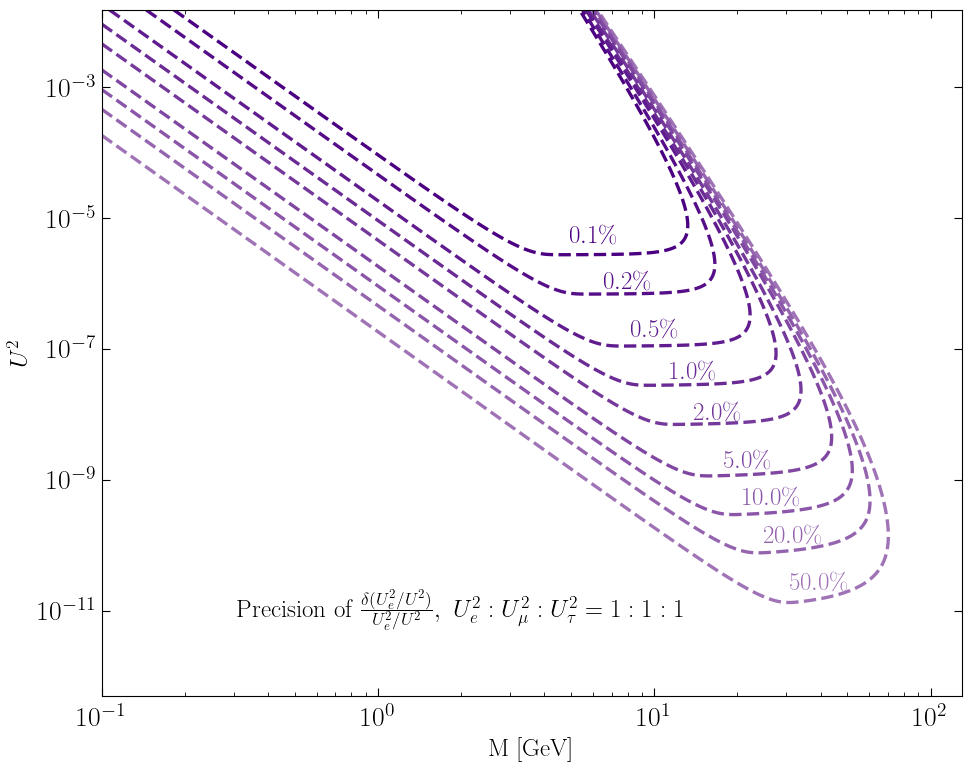

In [12]:
# ===================================================
# 1. Set model parameters for the sensitivity region
# ===================================================
Nmin = 4                    # Number of minimum observed events
NZ = 6e12                   # Number of produced Z bosons
LLP_model = HNL
mass_range = (0.1, 130)     # mass_range and coupling_range are also used to set the xlim and ylim of the final figure
coupling_range = (5e-13, 1.5e-2)

U2oUb2 = 3 # U^2 / U_\beta^2
precision_levels = np.array([0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
event_levels = (U2oUb2 - 1)/precision_levels**2

event_levels_specific = [] #Specific levels with solid lines and user-defined colors
colors_specific = []

model_parameters = {
    'LLP_model': HNL,
    'mass_range': mass_range,
    'coupling_range': coupling_range,
    'event_levels': event_levels,
    'event_levels_specific': event_levels_specific,
    'colors_specific': colors_specific,
    'NZ': NZ
}

# ===================================================
# 2. Set Detector geometry
# ===================================================
l0 = 0.04 * cm              # Background suppression cut given by minimal detectable displacement, can be set to 0 if backgrounds can be reduced in other ways
l0_contour = 0.04 * cm      # Set background-free for demonstration when plotting the contours

l_cyl = 11 * 100 * cm       # Length: 11 meters
d_cyl = 2 * 100 * 4.5 * cm  # Diameter: 9 meters
l1 = 0.5 * (1.5)**(1/3) * d_cyl**(2/3) * l_cyl**(1/3)  # Effective detector size

geometry_parameters = {
    'l0_contour': l0_contour,
    'l0': l0,
    'l1': l1
}

# ===================================================
# 3. Set parameters for the analytic sensitivity boundaries
# ===================================================
Show_boundaries = False     # Set to False if you don't want to show any analytic sensitivity boundaries
if Show_boundaries:
    boundary_list = [LLP_underproduced, LLP_prompt, LLP_escapes]
    Mmax_boundary = 74
    M_boundary = np.logspace(np.log10(0.1), np.log10(Mmax_boundary), 400)
    boundary_parameters = {
        'M_boundary': M_boundary,
        'boundary_list': boundary_list
    }
else:
    boundary_parameters = {
    }

# ===================================================
# 4. Add constraint regions for the LLP
# ===================================================
Show_constraints = False     # Set to False if you don't want to show any constraints
if Show_constraints:
    data_dir = "HNLConstraints/"
    HNL_Constraints_Direct = [
    data_dir + "gambitEWPD.csv",
    data_dir + "Umu-ATLAS-displaced.csv",
    data_dir + "Umu-ATLAS-prompt.csv",
    data_dir + "Umu-CHARM.csv",
    data_dir + "Umu-CMS-13TeV.csv",
    data_dir + "Umu-CMS-longlived.csv",
    data_dir + "Umu-DELPHI-longlived.csv",
    data_dir + "Umu-DELPHI-shortlived.csv",
    data_dir + "Umu-E949.csv",
    data_dir + "Umu-KEK.csv",
    data_dir + "Umu-NuTeV.csv",
    data_dir + "Umu-PS191.csv",
    data_dir + "Umu-SIN.csv"
    ]
    HNL_Constraints_Astro = [
    data_dir + "Umu-BBN_BoyarskyExtra.csv"
    ]
    HNL_seesaw = [
    data_dir + "seesaw.csv"
    ]

    constraints_parameters = {
        'Constraints_Direct': HNL_Constraints_Direct,
        'Constraints_Astro': HNL_Constraints_Astro,
        'Constraints_Add': HNL_seesaw
    }
else:
    constraints_parameters = {
    }

# ===================================================
# 5. Add labels for the sensitivity region
# ===================================================
label_font_size = 18
def generate_label(level):
    label = f"$ {round(level*100,2)} \%$"
    return label
    
Labels_Contour_positions_x = [40, 32, 27, 22, 17, 14, 10, 8, 6]
Labels_Contour_positions_y = [2.e-11, 1.04e-10, 4e-10, 1.5e-9, 8e-9, 3.4e-8, 1.5e-7, 8e-7, 4e-6]
Labels_Contour_labels = [generate_label(level) for level in precision_levels]
Labels_Contour = [Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels,label_font_size]

Labels_Contour_specific = [
    [2, 1e-11, r"Precision of $\frac{\delta(U_e^2/U^2)}{U_e^2/U^2}, \, \, U_e^2: U_\mu^2 : U_\tau^2 = 1:1:1$", 'black',label_font_size ]
]

if Show_boundaries:
    Labels_Boundaries = [
        [ 6.5, 2.2e-12, "too few HNLs produced", Dark_Red, label_font_size],
        [ 1.8, 1e-9, "HNLs decay \n outside detector", Dark_Blue, label_font_size],
        [38, 7e-6, "backgrounds \n not negligible", Dark_Green, label_font_size-2],
    ]
else:
    Labels_Boundaries = []
    
if Show_constraints:
    Labels_Constraints_Direct = [
        # [30, 2e-4, "DELPHI", 'black' ],
        # [9, 2e-6, "CMS", 'black' ],
        # [1, 2e-6, "NuTeV", 'black' ]
        [5.5, 3e-4, "excluded by direct searches", 'black', label_font_size + 2]
    ]
    
    Labels_Constraints_Astro = [
        [0.5, 1e-11, "disfavoured by BBN", 'black', label_font_size + 2]
    ]
    
    Labels_Constraints_Add = [
        [ 5, 0.42e-10, "seesaw", Dark_Brown, label_font_size + 2]
    ]
else:
    Labels_Constraints_Direct = []
    Labels_Constraints_Astro = []
    Labels_Constraints_Add = []

labels_parameters = {
    'Labels_Contour': Labels_Contour,
    'Labels_Contour_specific': Labels_Contour_specific,
    'Labels_Boundaries': Labels_Boundaries,
    'Labels_Constraints_Direct': Labels_Constraints_Direct,
    'Labels_Constraints_Astro': Labels_Constraints_Astro,
    'Labels_Constraints_Add': Labels_Constraints_Add
}

# ===================================================
# 6. Save the plot
# ===================================================
filename = f"Sensitivity_{LLP_model['name']}_precision_benchmark1.pdf"

# ===================================================
# 7. Run the main plot function
# ===================================================
Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename)

### HNL Sensitivity Plot (Contours for observation sensitivities, benchmark 2: Ue^2 : Umu^2 : Utau^2 = 2 : 199 : 199)

/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: overflow encountered in exp
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: invalid value encountered in subtract
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/4290521442.py:36: RuntimeWarning: divide by zero encountered in log10
  return M_grid, coupling_grid, np.log10(Nobs_grid)
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/4290521442.py:36: RuntimeWarning: invalid value encountered in log10
  return M_grid, coupling_grid, np.log10(Nobs_grid)


Plot saved to Sensitivity_HNL_precision_benchmark2.pdf


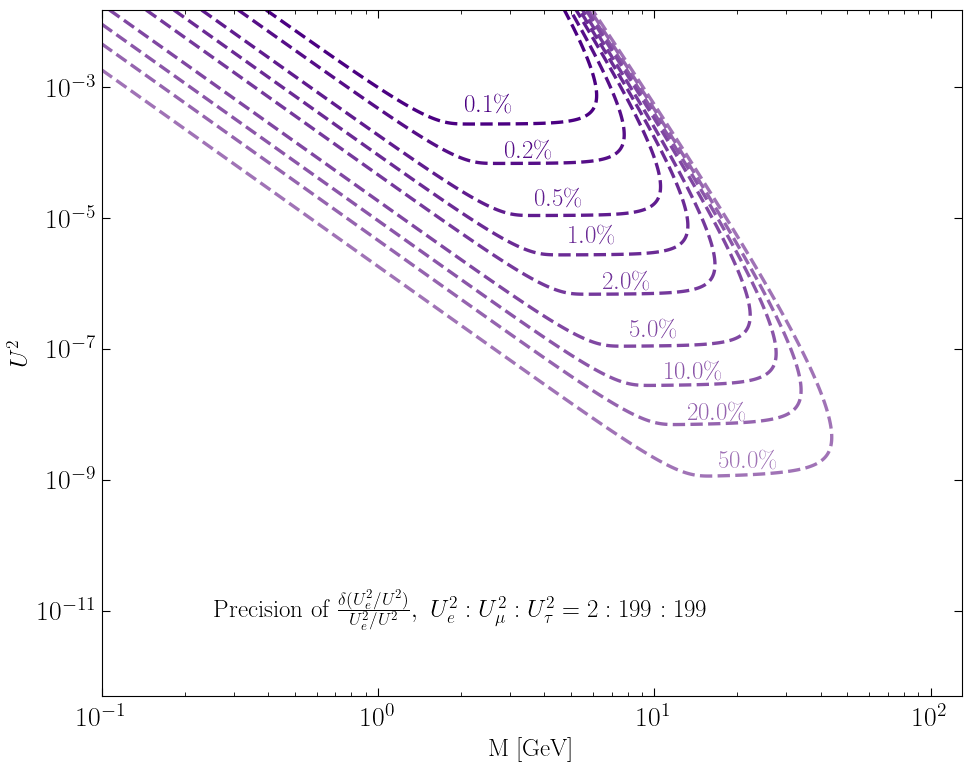

In [13]:
# ===================================================
# 1. Set model parameters for the sensitivity region
# ===================================================
Nmin = 4                    # Number of minimum observed events
NZ = 6e12                   # Number of produced Z bosons
LLP_model = HNL
mass_range = (0.1, 130)     # mass_range and coupling_range are also used to set the xlim and ylim of the final figure
coupling_range = (5e-13, 1.5e-2)

U2oUb2 = 200 # U^2 / U_\beta^2
precision_levels = np.array([0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001])
event_levels = (U2oUb2 - 1)/precision_levels**2

event_levels_specific = [] #Specific levels with solid lines and user-defined colors
colors_specific = []

model_parameters = {
    'LLP_model': HNL,
    'mass_range': mass_range,
    'coupling_range': coupling_range,
    'event_levels': event_levels,
    'event_levels_specific': event_levels_specific,
    'colors_specific': colors_specific,
    'NZ': NZ
}

# ===================================================
# 2. Set Detector geometry
# ===================================================
l0 = 0.04 * cm              # Background suppression cut given by minimal detectable displacement, can be set to 0 if backgrounds can be reduced in other ways
l0_contour = 0.04 * cm      # Set background-free for demonstration when plotting the contours

l_cyl = 11 * 100 * cm       # Length: 11 meters
d_cyl = 2 * 100 * 4.5 * cm  # Diameter: 9 meters
l1 = 0.5 * (1.5)**(1/3) * d_cyl**(2/3) * l_cyl**(1/3)  # Effective detector size

geometry_parameters = {
    'l0_contour': l0_contour,
    'l0': l0,
    'l1': l1
}

# ===================================================
# 3. Set parameters for the analytic sensitivity boundaries
# ===================================================
Show_boundaries = False     # Set to False if you don't want to show any analytic sensitivity boundaries
if Show_boundaries:
    boundary_list = [LLP_underproduced, LLP_prompt, LLP_escapes]
    Mmax_boundary = 74
    M_boundary = np.logspace(np.log10(0.1), np.log10(Mmax_boundary), 400)
    boundary_parameters = {
        'M_boundary': M_boundary,
        'boundary_list': boundary_list
    }
else:
    boundary_parameters = {
    }

# ===================================================
# 4. Add constraint regions for the LLP
# ===================================================
Show_constraints = False     # Set to False if you don't want to show any constraints
if Show_constraints:
    data_dir = "HNLConstraints/"
    HNL_Constraints_Direct = [
    data_dir + "gambitEWPD.csv",
    data_dir + "Umu-ATLAS-displaced.csv",
    data_dir + "Umu-ATLAS-prompt.csv",
    data_dir + "Umu-CHARM.csv",
    data_dir + "Umu-CMS-13TeV.csv",
    data_dir + "Umu-CMS-longlived.csv",
    data_dir + "Umu-DELPHI-longlived.csv",
    data_dir + "Umu-DELPHI-shortlived.csv",
    data_dir + "Umu-E949.csv",
    data_dir + "Umu-KEK.csv",
    data_dir + "Umu-NuTeV.csv",
    data_dir + "Umu-PS191.csv",
    data_dir + "Umu-SIN.csv"
    ]
    HNL_Constraints_Astro = [
    data_dir + "Umu-BBN_BoyarskyExtra.csv"
    ]
    HNL_seesaw = [
    data_dir + "seesaw.csv"
    ]

    constraints_parameters = {
        'Constraints_Direct': HNL_Constraints_Direct,
        'Constraints_Astro': HNL_Constraints_Astro,
        'Constraints_Add': HNL_seesaw
    }
else:
    constraints_parameters = {
    }

# ===================================================
# 5. Add labels for the sensitivity region
# ===================================================
label_font_size = 18
def generate_label(level):
    label = f"$ {round(level*100,2)} \%$"
    return label
    
Labels_Contour_positions_x = [22, 17, 14, 10, 8, 6, 4.5, 3.5, 2.5]
Labels_Contour_positions_y = [1.5e-9, 8e-9, 3.4e-8, 1.5e-7, 8e-7, 4e-6, 1.5e-5, 8e-5, 4e-4]
Labels_Contour_labels = [generate_label(level) for level in precision_levels]
Labels_Contour = [Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels,label_font_size ]

Labels_Contour_specific = [
    [2, 1e-11, r"Precision of $\frac{\delta(U_e^2/U^2)}{U_e^2/U^2}, \, \, U_e^2: U_\mu^2 : U_\tau^2 = 2:199:199$", 'black',label_font_size]
]

if Show_boundaries:
    Labels_Boundaries = [
        [ 6.5, 2.5e-12, "too few HNLs produced", Dark_Red],
        [ 1.8, 1e-9, "HNLs decay \n outside detector", Dark_Blue],
        [38, 7e-6, "backgrounds \n not negligible", Dark_Green],
    ]
else:
    Labels_Boundaries = []
    
if Show_constraints:
    Labels_Constraints_Direct = [
        [30, 2e-4, "DELPHI", 'black' ],
        [9, 2e-6, "CMS", 'black' ],
        [1, 2e-6, "NuTeV", 'black' ]
    ]
    
    Labels_Constraints_Astro = [
        [0.5, 1e-11, "disfavoured by BBN", 'black']
    ]
    
    Labels_Constraints_Add = [
        [ 5, 0.42e-10, "seasaw", Dark_Brown]
    ]
else:
    Labels_Constraints_Direct = []
    Labels_Constraints_Astro = []
    Labels_Constraints_Add = []

labels_parameters = {
    'Labels_Contour': Labels_Contour,
    'Labels_Contour_specific': Labels_Contour_specific,
    'Labels_Boundaries': Labels_Boundaries,
    'Labels_Constraints_Direct': Labels_Constraints_Direct,
    'Labels_Constraints_Astro': Labels_Constraints_Astro,
    'Labels_Constraints_Add': Labels_Constraints_Add
}

# ===================================================
# 6. Save the plot
# ===================================================
filename = f"Sensitivity_{LLP_model['name']}_precision_benchmark2.pdf"

# ===================================================
# 7. Run the main plot function
# ===================================================
Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename)

### ALP Sensitivity Plot (Fixed NZ)

/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: overflow encountered in exp
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/2021515509.py:63: RuntimeWarning: divide by zero encountered in divide
  epsilon_bound = -(pX(M) / M) / l0 / model['Gamma_vis'](M) * lambertw(term, k=-1)
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/2021515509.py:63: RuntimeWarning: invalid value encountered in multiply
  epsilon_bound = -(pX(M) / M) / l0 / model['Gamma_vis'](M) * lambertw(term, k=-1)
/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/2593697434.py:40: RuntimeWarning: invalid value encountered in multiply
  'coupling_from_epsilon': lambda eps: np.sqrt(eps) * f_ALP/mZ            # Inverse: epsilon -> c_gamma_gamma
/Users/yuanzhenli/Miniconda3/miniconda3/envs/py310/lib/python3.10/site-packages/matplotlib/cbook.py:1709: ComplexWarning

Plot saved to Sensitivity_ALP_NZ_6e+12.pdf


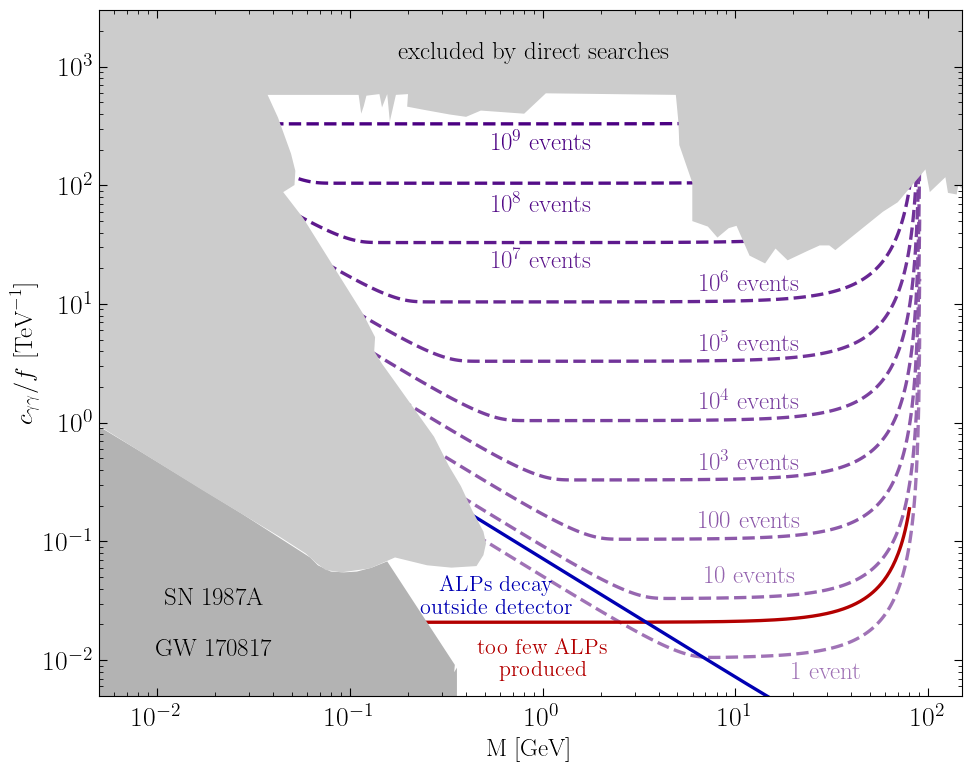

In [14]:
# ===================================================
# 1. Set model parameters for the sensitivity region
# ===================================================
NZ = 6e12                   # Number of produced Z bosons
LLP_model = ALP
mass_range = (5e-3, 150)     # mass_range and coupling_range are also used to set the xlim and ylim of the final figure
coupling_range = (5e-3, 3e3)
event_levels = [1, 10, 100, 1000, 1e4, 1e5, 1e6, 1e7, 1e8, 1e9]

event_levels_specific = [ ] #Specific levels with solid lines and user-defined colors
colors_specific = [ ]

model_parameters = {
    'LLP_model': LLP_model,
    'mass_range': mass_range,
    'coupling_range': coupling_range,
    'event_levels': event_levels,
    'event_levels_specific': event_levels_specific,
    'colors_specific': colors_specific,
    'NZ': NZ
}

# ===================================================
# 2. Set Detector geometry
# ===================================================
l0 = 0.0 * cm              # Background suppression cut given by minimal detectable displacement, can be set to 0 if backgrounds can be reduced in other ways
l0_contour = 0              # Set background-free for demonstration when plotting the contours

l_cyl = 11 * 100 * cm       # Length: 11 meters
d_cyl = 2 * 100 * 4.5 * cm  # Diameter: 9 meters
l1 = 0.5 * (1.5)**(1/3) * d_cyl**(2/3) * l_cyl**(1/3)  # Effective detector size

geometry_parameters = {
    'l0_contour': l0_contour,
    'l0': l0,
    'l1': l1
}

# ===================================================
# 3. Set parameters for the analytic sensitivity boundaries
# ===================================================
Show_boundaries = True     # Set to False if you don't want to show any analytic sensitivity boundaries
if Show_boundaries:
    boundary_list = [LLP_underproduced, LLP_prompt, LLP_escapes]
    Mmax_boundary = 80
    M_boundary = np.logspace(np.log10(0.1), np.log10(Mmax_boundary), 400)
    boundary_parameters = {
        'M_boundary': M_boundary,
        'boundary_list': boundary_list
    }
else:
    boundary_parameters = {
    }

# ===================================================
# 4. Add constraint regions for the LLP
# ===================================================
Show_constraints = True     # Set to False if you don't want to show any constraints
if Show_constraints:
    data_dir = "ALPConstraints/"
    
    ALP_Constraints_Direct = [
    data_dir + "Direct_constraints.csv"
    ]
    ALP_Constraints_Astro = [
    data_dir + "sn1897a.csv",
    data_dir + "GW170817.csv"
    ]

    constraints_parameters = {
        'Constraints_Direct': ALP_Constraints_Direct,
        'Constraints_Astro': ALP_Constraints_Astro,
        'Constraints_Add': [ ]
    }
else:
    constraints_parameters = {
    }

# ===================================================
# 5. Add labels for the sensitivity region
# ===================================================
label_font_size = 18
def generate_label(N_events):
    if N_events >= 1000:
        label = f"$10^{int(np.log10(N_events))}$ events"
    elif N_events >= 10:
        label = f"${int(N_events)}$ events"
    else:
        label = f"{int(N_events)} event{'s' if N_events > 1 else ''}"
    return label
    
Labels_Contour_positions_x = [30, 12, 12, 12, 12, 12, 12, 1, 1, 1]
Labels_Contour_positions_y = [7e-3, 4.5e-2, 1.3e-1, 4e-1, 1.3e0, 4e0, 1.3e1, 2e1, 6e1, 2e2]
Labels_Contour_labels = [generate_label(level) for level in event_levels]
Labels_Contour = [Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels,label_font_size]

Labels_Contour_specific = [
   
]

if Show_boundaries:
    Labels_Boundaries = [
    [ 1e0, 1e-2, "too few ALPs \n produced", Dark_Red,label_font_size-2],
    [ 5.7e-1, 3.4e-2, "ALPs decay \n outside detector", Dark_Blue,label_font_size-2]
    ]
else:
    Labels_Boundaries = []
    
if Show_constraints:
    Labels_Constraints_Direct = [
        # [1.5e-1, 1e-1, "MiniBoone", 'black'],
        # [5e-2, 1e0, "Beam Dump", 'black'],
        # [5e-1, 1.2e3, "LEP I and II", 'black'],
        # [20, 1e2, "LHC (PbPb)", 'black']
        [0.9, 1.3e3, "excluded by direct searches", 'black',label_font_size]
    ]
    
    Labels_Constraints_Astro = [
         [2e-2, 2e-2, "SN 1987A \n\n GW 170817", 'black',label_font_size]
    ]
    
    Labels_Constraints_Add = [
    ]
else:
    Labels_Constraints_Direct = []
    Labels_Constraints_Astro = []
    Labels_Constraints_Add = []

labels_parameters = {
    'Labels_Contour': Labels_Contour,
    'Labels_Contour_specific': Labels_Contour_specific,
    'Labels_Boundaries': Labels_Boundaries,
    'Labels_Constraints_Direct': Labels_Constraints_Direct,
    'Labels_Constraints_Astro': Labels_Constraints_Astro,
    'Labels_Constraints_Add': Labels_Constraints_Add
}

# ===================================================
# 6. Save the plot
# ===================================================
filename = f"Sensitivity_{LLP_model['name']}_NZ_{NZ:.0e}.pdf"

# ===================================================
# 7. Run the main plot function
# ===================================================
Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename)

### ALP Sensitivity Plot (Fixed Nobs)

/var/folders/fd/lvz_hbf155n1p3y74_b826240000gp/T/ipykernel_41448/218372872.py:51: RuntimeWarning: overflow encountered in exp
  geom_factor = (np.exp(-l0 / decay_len) - np.exp(-l1 / decay_len))


Plot saved to Sensitivity_ALP_Nmin_4e+00.pdf


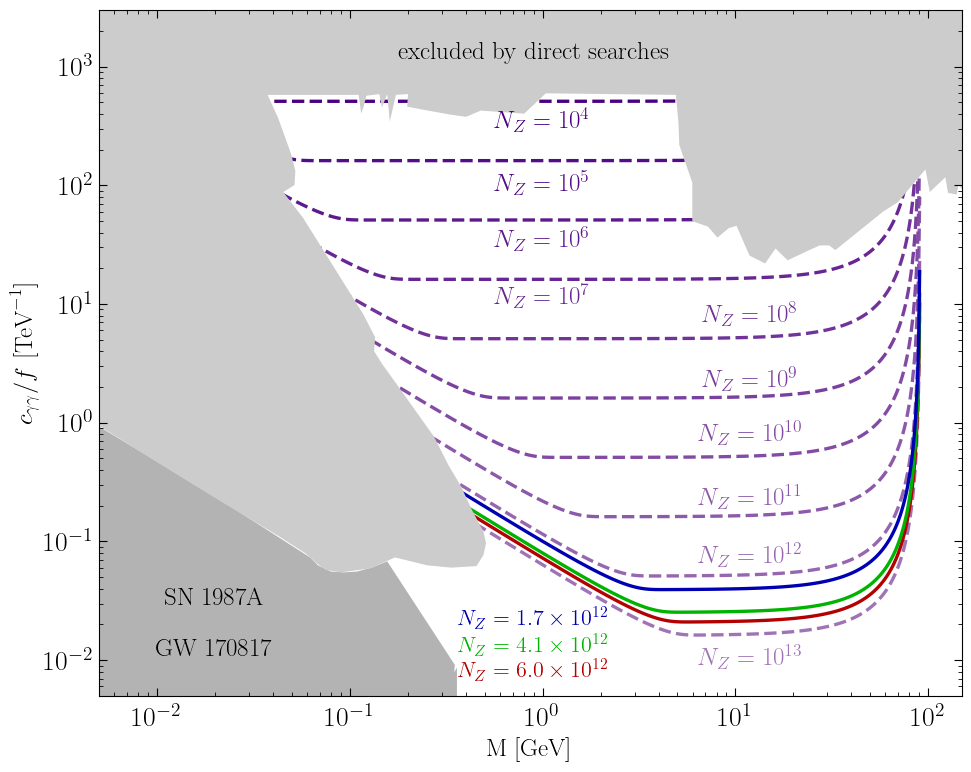

In [15]:
# ===================================================
# 1. Set model parameters for the sensitivity region
# ===================================================
NZ = 1e13                   # Number of produced Z bosons
LLP_model = ALP
mass_range = (5e-3, 150)     # mass_range and coupling_range are also used to set the xlim and ylim of the final figure
coupling_range = (5e-3, 3e3)

NZ_levels = np.array([1e13, 1e12, 1e11, 1e10, 1e9, 1e8, 1e7, 1e6, 1e5, 1e4])
event_levels = Nmin * NZ / NZ_levels

NZ_levels_specific = np.array([6e12, 4.1e12, 1.7e12])
event_levels_specific = Nmin * NZ / NZ_levels_specific #Specific levels with solid lines and user-defined colors
colors_specific = [Dark_Red, Dark_Green, Dark_Blue]

model_parameters = {
    'LLP_model': LLP_model,
    'mass_range': mass_range,
    'coupling_range': coupling_range,
    'event_levels': event_levels,
    'event_levels_specific': event_levels_specific,
    'colors_specific': colors_specific,
    'NZ': NZ
}

# ===================================================
# 2. Set Detector geometry
# ===================================================
l0 = 0.0 * cm              # Background suppression cut given by minimal detectable displacement, can be set to 0 if backgrounds can be reduced in other ways
l0_contour = 0              # Set background-free for demonstration when plotting the contours

l_cyl = 11 * 100 * cm       # Length: 11 meters
d_cyl = 2 * 100 * 4.5 * cm  # Diameter: 9 meters
l1 = 0.5 * (1.5)**(1/3) * d_cyl**(2/3) * l_cyl**(1/3)  # Effective detector size

geometry_parameters = {
    'l0_contour': l0_contour,
    'l0': l0,
    'l1': l1
}

# ===================================================
# 3. Set parameters for the analytic sensitivity boundaries
# ===================================================
Show_boundaries = False     # Set to False if you don't want to show any analytic sensitivity boundaries
if Show_boundaries:
    boundary_list = [LLP_underproduced, LLP_prompt, LLP_escapes]
    Mmax_boundary = 74
    M_boundary = np.logspace(np.log10(0.1), np.log10(Mmax_boundary), 400)
    boundary_parameters = {
        'M_boundary': M_boundary,
        'boundary_list': boundary_list
    }
else:
    boundary_parameters = {
    }

# ===================================================
# 4. Add constraint regions for the LLP
# ===================================================
Show_constraints = True     # Set to False if you don't want to show any constraints
if Show_constraints:
    data_dir = "ALPConstraints/"
    
    ALP_Constraints_Direct = [
    data_dir + "Direct_constraints.csv"
    ]
    ALP_Constraints_Astro = [
    data_dir + "sn1897a.csv",
    data_dir + "GW170817.csv"
    ]

    constraints_parameters = {
        'Constraints_Direct': ALP_Constraints_Direct,
        'Constraints_Astro': ALP_Constraints_Astro,
        'Constraints_Add': [ ]
    }
else:
    constraints_parameters = {
    }

# ===================================================
# 5. Add labels for the sensitivity region
# ===================================================
label_font_size = 18
def generate_label(NZ):
    label = f"$N_Z = 10^{{{int(np.log10(NZ))}}}$"
    return label
    
Labels_Contour_positions_x = [12, 12, 12, 12, 12, 12, 1, 1, 1, 1]
Labels_Contour_positions_y = [9e-3, 6.5e-2, 2e-1, 7e-1, 2e0, 7e0, 1e1, 3e1, 9e1, 3e2]
Labels_Contour_labels = [generate_label(level) for level in NZ_levels]
Labels_Contour = [Labels_Contour_positions_x, Labels_Contour_positions_y, Labels_Contour_labels,label_font_size]

Labels_Contour_specific = [
    [0.9, 8e-3, r"$N_Z = 6.0 \times 10^{12}$", Dark_Red,label_font_size-2],
    [0.9, 2.2e-2, r"$N_Z = 1.7 \times 10^{12}$", Dark_Blue,label_font_size-2],
    [0.9, 1.32e-2, r"$N_Z = 4.1 \times 10^{12}$", Dark_Green,label_font_size-2]
]

if Show_boundaries:
    Labels_Boundaries = [
    [ 5e-2, 1e-2, "too few HNLs produced", Dark_Red,label_font_size],
    [ 5e-2, 3e-2, "HNLs decay \n outside detector", Dark_Blue,label_font_size]
    ]
else:
    Labels_Boundaries = []
    
if Show_constraints:
    Labels_Constraints_Direct = [
        # [1.5e-1, 1e-1, "MiniBoone", 'black'],
        # [5e-2, 1e0, "Beam Dump", 'black'],
        # [5e-1, 1.2e3, "LEP I and II", 'black'],
        # [20, 1e2, "LHC (PbPb)", 'black']
        [0.9, 1.3e3, "excluded by direct searches", 'black',label_font_size]
    ]
    
    Labels_Constraints_Astro = [
         [2e-2, 2e-2, "SN 1987A \n\n GW 170817", 'black',label_font_size]
    ]
    
    Labels_Constraints_Add = [
    ]
else:
    Labels_Constraints_Direct = []
    Labels_Constraints_Astro = []
    Labels_Constraints_Add = []


labels_parameters = {
    'Labels_Contour': Labels_Contour,
    'Labels_Contour_specific': Labels_Contour_specific,
    'Labels_Boundaries': Labels_Boundaries,
    'Labels_Constraints_Direct': Labels_Constraints_Direct,
    'Labels_Constraints_Astro': Labels_Constraints_Astro,
    'Labels_Constraints_Add': Labels_Constraints_Add
}

# ===================================================
# 6. Save the plot
# ===================================================
filename = f"Sensitivity_{LLP_model['name']}_Nmin_{Nmin:.0e}.pdf"

# ===================================================
# 7. Run the main plot function
# ===================================================
Plot_Sensitivity_Region(model_parameters, geometry_parameters, boundary_parameters, constraints_parameters, labels_parameters, filename)